<a href="https://colab.research.google.com/github/Samy-Annasri/ReverseForecastAttack/blob/main/ReverseForecastAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT

In [33]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [34]:
import sys
import os

def in_colab():
    return 'google.colab' in sys.modules

if in_colab():
    repo_name = "ReverseForecastAttack"
    ipynb_name = "ReverseForecasAttack.ipynb"
    cwd = os.getcwd()
    basename = os.path.basename(cwd)

    if basename != repo_name:
        if not os.path.exists(repo_name):
            !git clone https://github.com/Samy-Annasri/ReverseForecastAttack.git
        %cd {repo_name}
        %rm {ipynb_name}



In [35]:
'''
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
'''

"\ndef set_seed(seed=42):\n    random.seed(seed)\n    np.random.seed(seed)\n    torch.manual_seed(seed)\n    torch.cuda.manual_seed_all(seed)\n    os.environ['PYTHONHASHSEED'] = str(seed)\n    torch.backends.cudnn.deterministic = True\n    torch.backends.cudnn.benchmark = False\n\nset_seed(42)\n"

In [36]:
# just some code for testing the import
'''
import sys

if 'prepare_stock_dataset' in globals():
    del globals()['prepare_stock_dataset']

module_name = 'utils.setup_google_stock_dataset'
if module_name in sys.modules:
    del sys.modules[module_name]
'''

"\nimport sys\n\nif 'prepare_stock_dataset' in globals():\n    del globals()['prepare_stock_dataset']\n\nmodule_name = 'utils.setup_google_stock_dataset'\nif module_name in sys.modules:\n    del sys.modules[module_name]\n"

## STEP 1: PREP DATA

In [37]:
google_data = pd.read_csv("data/HistoricalData_1747091015337.csv")
google_data['Date'] = pd.to_datetime(google_data['Date'])
google_data = google_data.sort_values(by='Date')
display(google_data)

,Date,Close/Last,Volume,Open,High,Low
1254,2020-05-13,$67.4665,36251700,$68.8525,$69.2741,$66.42
1253,2020-05-14,$67.8065,32061540,$66.751,$67.871,$66.1955
1252,2020-05-15,$68.6595,34154940,$67.50,$68.724,$66.95
1251,2020-05-18,$69.197,36479280,$68.0875,$69.6163,$67.7125
1250,2020-05-19,$68.6743,25612980,$69.3499,$69.60,$68.6743
...,...,...,...,...,...,...
4,2025-05-05,$166.05,15309340,$164.515,$167.10,$164.47
3,2025-05-06,$165.20,10691950,$163.96,$166.74,$163.13
2,2025-05-07,$152.80,78900430,$166.07,$166.99,$149.4901
1,2025-05-08,$155.75,38387510,$155.92,$157.41,$154.10


In [38]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
sequence_length = 30
result = prepare_stock_dataset(google_data)

train_loader = result['train_loader']
test_loader = result['test_loader']
train_size = result['train_size']
min_max = result['min_max']
dates = result['dates']
price_min, price_max = min_max['Close/Last']


## STEP 2: TRAIN NORMAL LSTM

In [39]:
from utils.train_model import train_model
from models.lstm import SimpleLSTM
model_google = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google.parameters(), lr=0.001)
num_epochs = 30
train_model(model_google, loss_fn, optimizer, num_epochs, train_loader)

Epoch [1/30], Train Loss: 0.0365
Epoch [2/30], Train Loss: 0.0087
Epoch [3/30], Train Loss: 0.0018
Epoch [4/30], Train Loss: 0.0011
Epoch [5/30], Train Loss: 0.0009
Epoch [6/30], Train Loss: 0.0009
Epoch [7/30], Train Loss: 0.0009
Epoch [8/30], Train Loss: 0.0009
Epoch [9/30], Train Loss: 0.0009
Epoch [10/30], Train Loss: 0.0008
Epoch [11/30], Train Loss: 0.0008
Epoch [12/30], Train Loss: 0.0008
Epoch [13/30], Train Loss: 0.0008
Epoch [14/30], Train Loss: 0.0008
Epoch [15/30], Train Loss: 0.0008
Epoch [16/30], Train Loss: 0.0008
Epoch [17/30], Train Loss: 0.0007
Epoch [18/30], Train Loss: 0.0008
Epoch [19/30], Train Loss: 0.0007
Epoch [20/30], Train Loss: 0.0008
Epoch [21/30], Train Loss: 0.0007
Epoch [22/30], Train Loss: 0.0007
Epoch [23/30], Train Loss: 0.0007
Epoch [24/30], Train Loss: 0.0008
Epoch [25/30], Train Loss: 0.0008
Epoch [26/30], Train Loss: 0.0007
Epoch [27/30], Train Loss: 0.0006
Epoch [28/30], Train Loss: 0.0006
Epoch [29/30], Train Loss: 0.0007
Epoch [30/30], Train Lo

In [40]:
from utils.google_eval import evaluate_model_google
results = evaluate_model_google(model_google, test_loader, dates, train_size)

real_values = results['real_values']
predicted_values = results['predicted_values']
test_dates = results['test_dates']

In [41]:
# Computes scalar similarity (cosine similarity) between true and predicted values.
# Higher values indicate that adversarial predictions remain directionally aligned
# with the true values, suggesting stealthy and rational attacks!
def scalar_similarity(y_true, y_pred):
    numerator = np.dot(y_true, y_pred)
    denominator = np.linalg.norm(y_true) * np.linalg.norm(y_pred)
    if denominator == 0:
        return 0.0
    return numerator / denominator

In [42]:
# Creation of the tab result for plotting adversial attack result
models = ['LSTM','RNN','GRU']
metrics = ['MAE', "RMSE", 'SIM']

row_index = pd.MultiIndex.from_product([models, metrics], names=['Model', 'Metric'])

attacks = ['NA','PAST','REV']
epsilons = {
    'NA': [0],
    'PAST':[0],
    'REV':[0.01,0.1,0.2],
}

col_tuples = []
for atk, eps_list in epsilons.items():
    for eps in eps_list:
        col_tuples.append((atk, f"{eps:.2f}"))

col_index = pd.MultiIndex.from_tuples(col_tuples, names=['Attack', 'ε'])

res_tab = pd.DataFrame(index=row_index, columns=col_index, dtype=float)

print(res_tab)

Attack         NA PAST  REV          
ε            0.00 0.00 0.01 0.10 0.20
Model Metric                         
LSTM  MAE     NaN  NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN  NaN
RNN   MAE     NaN  NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN  NaN
GRU   MAE     NaN  NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN  NaN


LSTM | NA – Epsilon 0.00 – MAE: 4.6558 | SIM: 0.9996


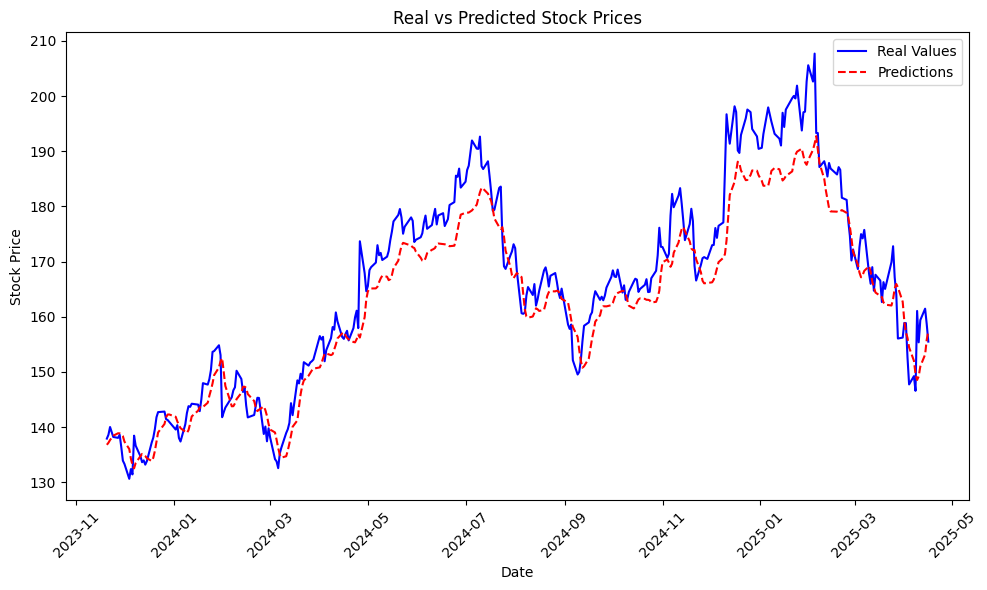

In [43]:
from utils.log_and_plot import log_and_plot_predictions
# Denormalize
true_values_denorm = real_values * (price_max - price_min) + price_min
predictions_denorm = predicted_values * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm,
    predictions=predictions_denorm,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [44]:
display(res_tab)

Attack              NA PAST  REV          
ε                 0.00 0.00 0.01 0.10 0.20
Model Metric                              
LSTM  MAE     4.655826  NaN  NaN  NaN  NaN
      RMSE    5.859856  NaN  NaN  NaN  NaN
      SIM     0.999625  NaN  NaN  NaN  NaN
RNN   MAE          NaN  NaN  NaN  NaN  NaN
      RMSE         NaN  NaN  NaN  NaN  NaN
      SIM          NaN  NaN  NaN  NaN  NaN
GRU   MAE          NaN  NaN  NaN  NaN  NaN
      RMSE         NaN  NaN  NaN  NaN  NaN
      SIM          NaN  NaN  NaN  NaN  NaN

## STEP 3: REVERSE DATA

In [45]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
google_data_reversed = google_data
result_rev = prepare_stock_dataset(google_data_reversed,reverse=True)
train_loader_rev = result_rev['train_loader']
test_loader_rev = result_rev['test_loader']
train_size_rev = result['train_size']
min_max_rev = result['min_max']
dates_rev = result_rev['dates']
price_min_rev, price_max_rev = min_max['Close/Last']


## STEP 4: TRAIN REVERSE LSTM

In [46]:
model_google_rev = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
optimizer_rev = torch.optim.Adam(model_google_rev.parameters(), lr=0.001)

train_model(model_google_rev, loss_fn, optimizer_rev, num_epochs, train_loader_rev)

Epoch [1/30], Train Loss: 0.0436
Epoch [2/30], Train Loss: 0.0075
Epoch [3/30], Train Loss: 0.0017
Epoch [4/30], Train Loss: 0.0012
Epoch [5/30], Train Loss: 0.0010
Epoch [6/30], Train Loss: 0.0009
Epoch [7/30], Train Loss: 0.0008
Epoch [8/30], Train Loss: 0.0008
Epoch [9/30], Train Loss: 0.0008
Epoch [10/30], Train Loss: 0.0008
Epoch [11/30], Train Loss: 0.0008
Epoch [12/30], Train Loss: 0.0008
Epoch [13/30], Train Loss: 0.0008
Epoch [14/30], Train Loss: 0.0008
Epoch [15/30], Train Loss: 0.0007
Epoch [16/30], Train Loss: 0.0007
Epoch [17/30], Train Loss: 0.0007
Epoch [18/30], Train Loss: 0.0007
Epoch [19/30], Train Loss: 0.0006
Epoch [20/30], Train Loss: 0.0007
Epoch [21/30], Train Loss: 0.0006
Epoch [22/30], Train Loss: 0.0006
Epoch [23/30], Train Loss: 0.0006
Epoch [24/30], Train Loss: 0.0005
Epoch [25/30], Train Loss: 0.0006
Epoch [26/30], Train Loss: 0.0006
Epoch [27/30], Train Loss: 0.0005
Epoch [28/30], Train Loss: 0.0006
Epoch [29/30], Train Loss: 0.0005
Epoch [30/30], Train Lo

LSTM | PAST – Epsilon 0.00 – MAE: 5.8932 | SIM: 0.9997


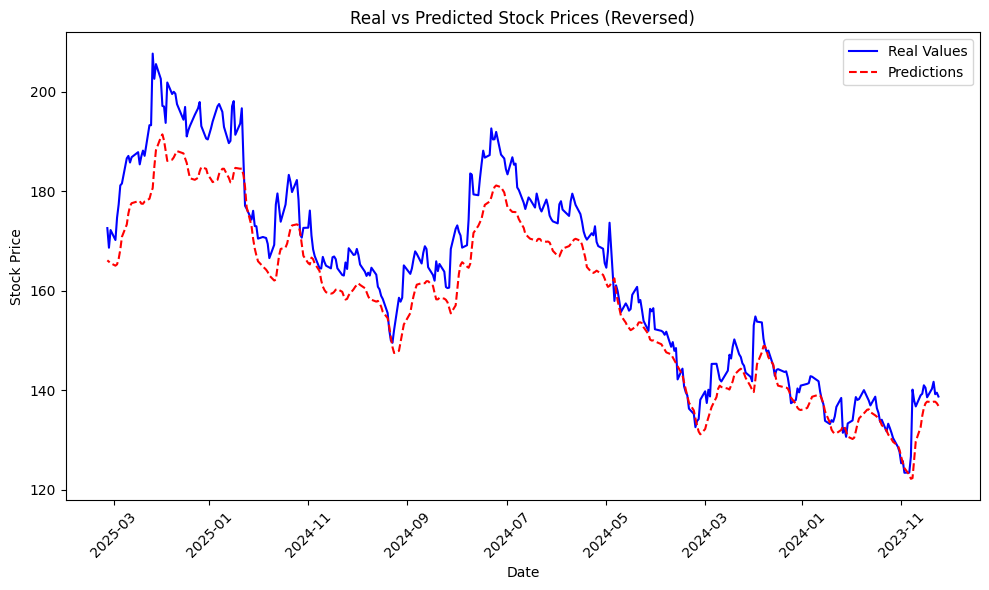

In [47]:
results_rev = evaluate_model_google(model_google_rev, test_loader_rev, dates_rev, train_size_rev)

real_values_rev = results_rev['real_values']
predicted_values_rev = results_rev['predicted_values']
test_dates_rev = results_rev['test_dates']

min_len = min(len(test_dates_rev), len(real_values_rev), len(predicted_values_rev))
true_values_denorm_rev = (real_values_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
predictions_denorm_rev = (predicted_values_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
test_dates_rev = test_dates_rev[:min_len]

log_and_plot_predictions(
    true_values=true_values_denorm_rev,
    predictions=predictions_denorm_rev,
    test_dates=test_dates_rev,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='PAST',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True,
    reverse=True
)

# STEP 5: ATTACK FGSM NO AUTOREGRESSIVELY (FIRST ATTEMPT)

LSTM | REV – Epsilon 0.01 – MAE: 4.6129 | SIM: 0.9996


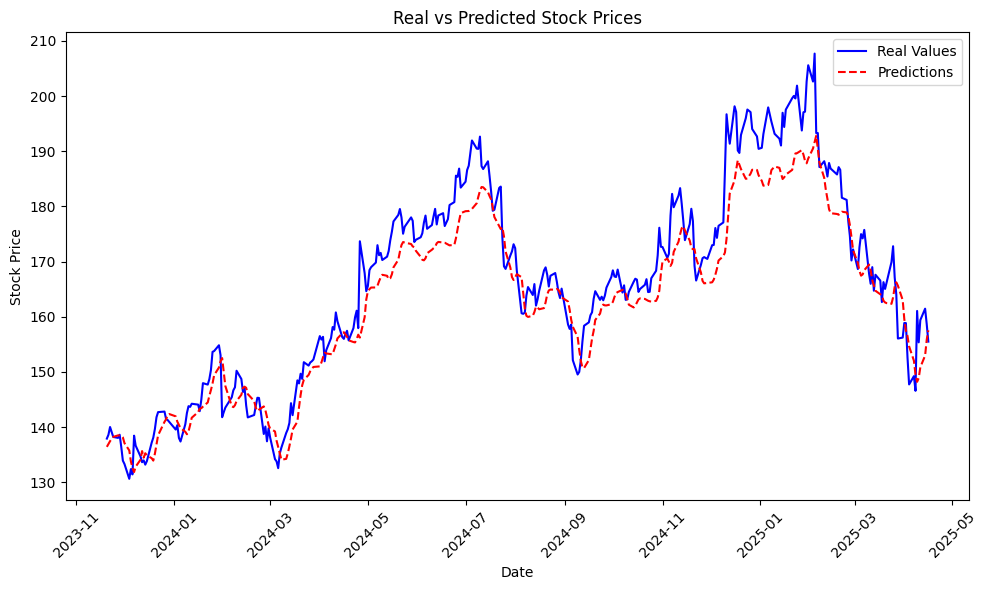

LSTM | REV – Epsilon 0.10 – MAE: 4.7777 | SIM: 0.9995


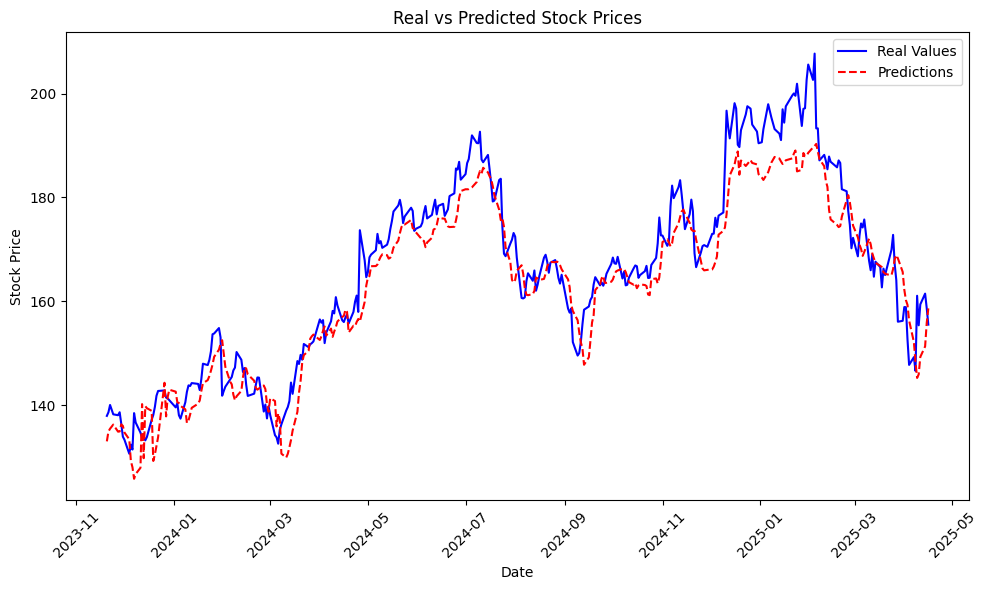

LSTM | REV – Epsilon 0.20 – MAE: 6.0756 | SIM: 0.9991


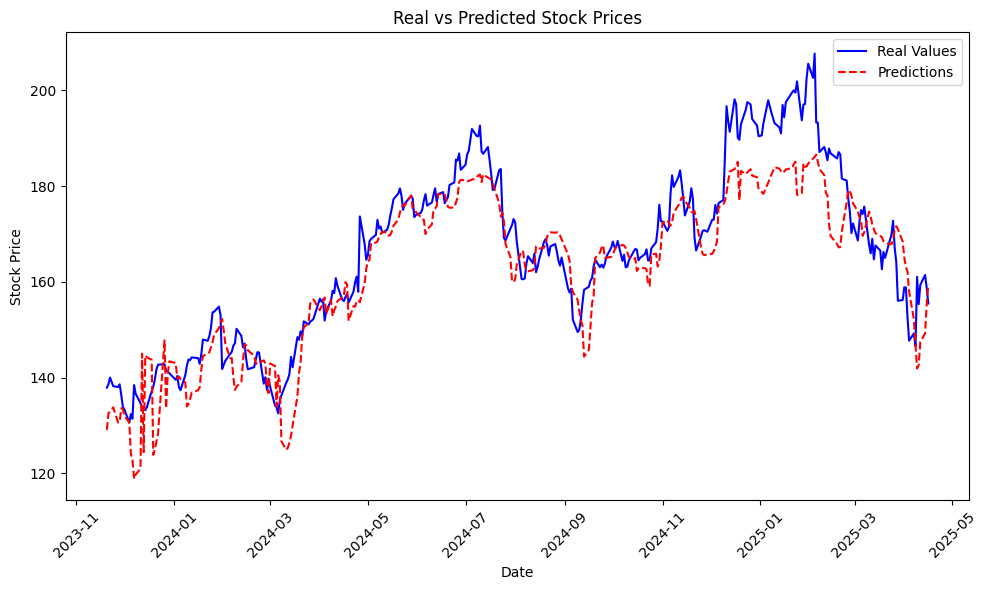

In [48]:
from attack.rev import reverse_forecast_attack

epsilons = [0.01, 0.1, 0.2]
results = reverse_forecast_attack(
    model_google_rev, model_google,
    test_loader_rev, test_loader,
    epsilons,
    price_min, price_max
)

for esp, (true_vals, preds) in results.items():
  log_and_plot_predictions(
      true_values=true_vals,
      predictions=preds,
      test_dates=test_dates,
      true_values_rolling=None,
      predictions_rolling=None,
      model_name='LSTM',
      attack_name='REV',
      epsilon=esp,
      res_tab=res_tab,
      similarity_fn=scalar_similarity,
      google=True
  )

In [49]:
display(res_tab)

Attack              NA      PAST       REV                    
ε                 0.00      0.00      0.01      0.10      0.20
Model Metric                                                  
LSTM  MAE     4.655826  5.893160  4.612915  4.777683  6.075597
      RMSE    5.859856  7.200629  5.802410  5.994869  7.821719
      SIM     0.999625  0.999700  0.999628  0.999535  0.999135
RNN   MAE          NaN       NaN       NaN       NaN       NaN
      RMSE         NaN       NaN       NaN       NaN       NaN
      SIM          NaN       NaN       NaN       NaN       NaN
GRU   MAE          NaN       NaN       NaN       NaN       NaN
      RMSE         NaN       NaN       NaN       NaN       NaN
      SIM          NaN       NaN       NaN       NaN       NaN

## STEP 5 FOR OTHER MODELS (RNN,CNN)

In [50]:
from utils.train_model import train_model
from models.rnn import SimpleRNN
model_google_rnn = SimpleRNN(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google_rnn.parameters(), lr=0.001)
num_epochs = 30
train_model(model_google_rnn, loss_fn, optimizer, num_epochs, train_loader)

Epoch [1/30], Train Loss: 0.0256
Epoch [2/30], Train Loss: 0.0023
Epoch [3/30], Train Loss: 0.0006
Epoch [4/30], Train Loss: 0.0005
Epoch [5/30], Train Loss: 0.0005
Epoch [6/30], Train Loss: 0.0004
Epoch [7/30], Train Loss: 0.0004
Epoch [8/30], Train Loss: 0.0004
Epoch [9/30], Train Loss: 0.0004
Epoch [10/30], Train Loss: 0.0004
Epoch [11/30], Train Loss: 0.0004
Epoch [12/30], Train Loss: 0.0004
Epoch [13/30], Train Loss: 0.0005
Epoch [14/30], Train Loss: 0.0005
Epoch [15/30], Train Loss: 0.0004
Epoch [16/30], Train Loss: 0.0004
Epoch [17/30], Train Loss: 0.0004
Epoch [18/30], Train Loss: 0.0003
Epoch [19/30], Train Loss: 0.0004
Epoch [20/30], Train Loss: 0.0003
Epoch [21/30], Train Loss: 0.0003
Epoch [22/30], Train Loss: 0.0004
Epoch [23/30], Train Loss: 0.0004
Epoch [24/30], Train Loss: 0.0004
Epoch [25/30], Train Loss: 0.0003
Epoch [26/30], Train Loss: 0.0003
Epoch [27/30], Train Loss: 0.0003
Epoch [28/30], Train Loss: 0.0003
Epoch [29/30], Train Loss: 0.0003
Epoch [30/30], Train Lo

RNN | NA – Epsilon 0.00 – MAE: 4.1859 | SIM: 0.9998


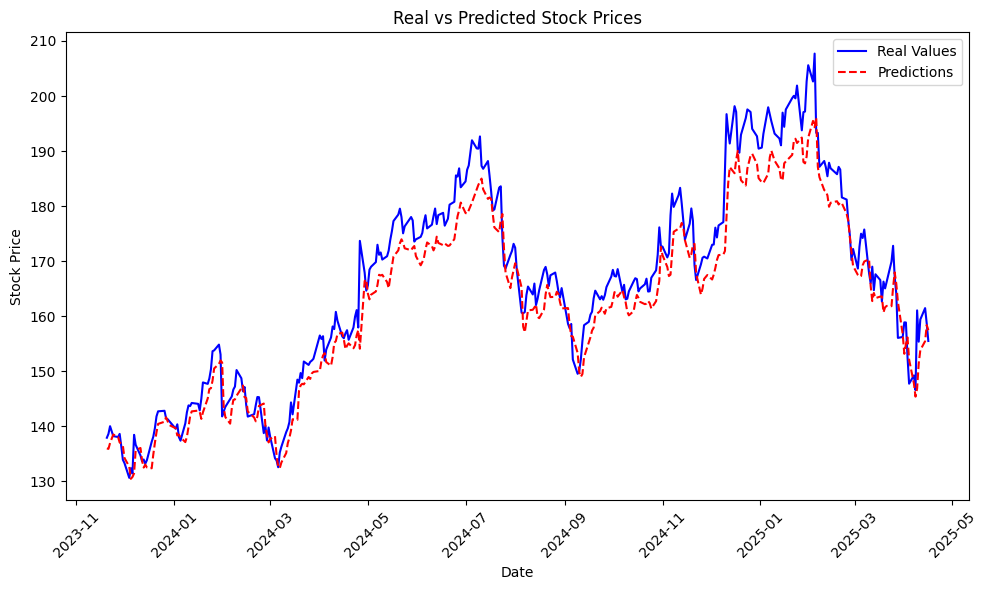

In [51]:
results_rnn = evaluate_model_google(model_google_rnn, test_loader, dates, train_size)

real_values_rnn = results_rnn['real_values']
predicted_values_rnn = results_rnn['predicted_values']
test_dates = results_rnn['test_dates']

true_values_denorm_rnn = real_values_rnn * (price_max - price_min) + price_min
predictions_denorm_rnn = predicted_values_rnn * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm_rnn,
    predictions=predictions_denorm_rnn,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='RNN',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [52]:
model_google_rnn_rev = SimpleRNN(input_size=5, hidden_size=64, output_size=1, num_layers=2)
optimizer_rev = torch.optim.Adam(model_google_rnn_rev.parameters(), lr=0.001)

train_model(model_google_rnn_rev, loss_fn, optimizer_rev, num_epochs, train_loader_rev)

Epoch [1/30], Train Loss: 0.0191
Epoch [2/30], Train Loss: 0.0011
Epoch [3/30], Train Loss: 0.0004
Epoch [4/30], Train Loss: 0.0003
Epoch [5/30], Train Loss: 0.0003
Epoch [6/30], Train Loss: 0.0003
Epoch [7/30], Train Loss: 0.0002
Epoch [8/30], Train Loss: 0.0002
Epoch [9/30], Train Loss: 0.0003
Epoch [10/30], Train Loss: 0.0002
Epoch [11/30], Train Loss: 0.0002
Epoch [12/30], Train Loss: 0.0002
Epoch [13/30], Train Loss: 0.0002
Epoch [14/30], Train Loss: 0.0002
Epoch [15/30], Train Loss: 0.0002
Epoch [16/30], Train Loss: 0.0002
Epoch [17/30], Train Loss: 0.0002
Epoch [18/30], Train Loss: 0.0002
Epoch [19/30], Train Loss: 0.0002
Epoch [20/30], Train Loss: 0.0002
Epoch [21/30], Train Loss: 0.0002
Epoch [22/30], Train Loss: 0.0002
Epoch [23/30], Train Loss: 0.0002
Epoch [24/30], Train Loss: 0.0002
Epoch [25/30], Train Loss: 0.0002
Epoch [26/30], Train Loss: 0.0001
Epoch [27/30], Train Loss: 0.0002
Epoch [28/30], Train Loss: 0.0002
Epoch [29/30], Train Loss: 0.0002
Epoch [30/30], Train Lo

RNN | PAST – Epsilon 0.00 – MAE: 2.4405 | SIM: 0.9999


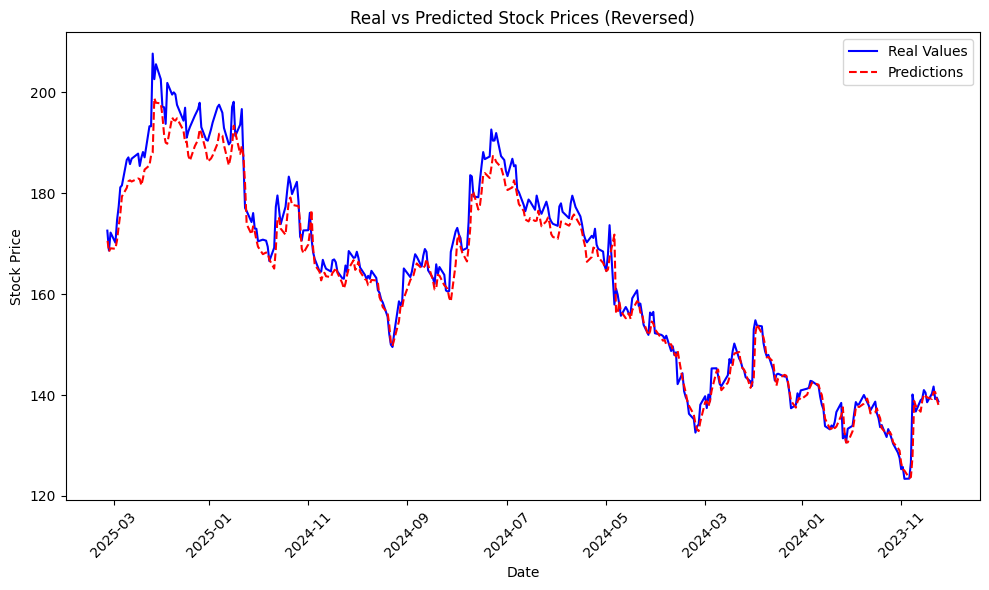

In [53]:
results_rnn_rev = evaluate_model_google(model_google_rnn_rev, test_loader_rev, dates_rev, train_size_rev)

real_values_rnn_rev = results_rnn_rev['real_values']
predicted_values_rnn_rev = results_rnn_rev['predicted_values']
test_dates_rev = results_rnn_rev['test_dates']

min_len = min(len(test_dates_rev), len(real_values_rnn_rev), len(predicted_values_rnn_rev))
true_values_denorm_rnn_rev = (real_values_rnn_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
predictions_denorm_rnn_rev = (predicted_values_rnn_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
test_dates_rev = test_dates_rev[:min_len]

log_and_plot_predictions(
    true_values=true_values_denorm_rnn_rev,
    predictions=predictions_denorm_rnn_rev,
    test_dates=test_dates_rev,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='RNN',
    attack_name='PAST',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True,
    reverse=True
)

RNN | REV – Epsilon 0.01 – MAE: 4.2265 | SIM: 0.9998


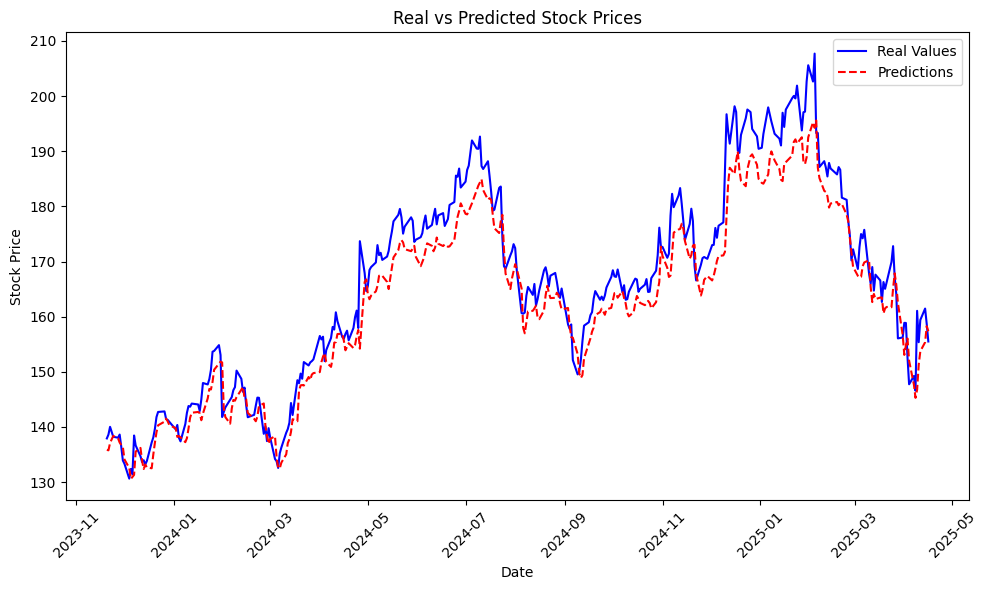

RNN | REV – Epsilon 0.10 – MAE: 4.8821 | SIM: 0.9997


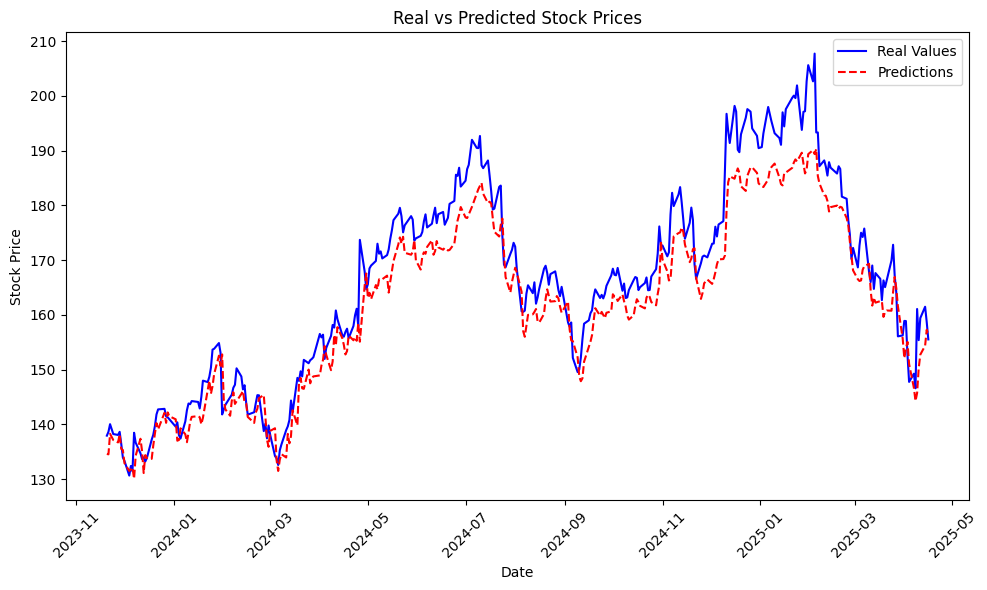

RNN | REV – Epsilon 0.20 – MAE: 6.4679 | SIM: 0.9995


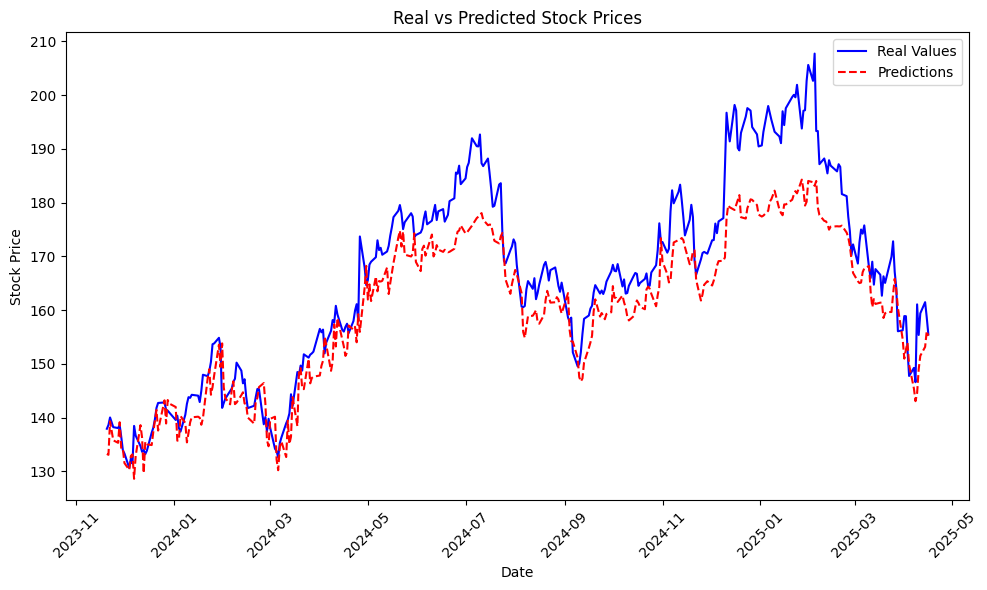

In [54]:
from attack.rev import reverse_forecast_attack

epsilons = [0.01, 0.1, 0.2]
results_rev_rnn = reverse_forecast_attack(
    model_google_rnn_rev, model_google_rnn,
    test_loader_rev, test_loader,
    epsilons,
    price_min, price_max
)

for esp, (true_vals, preds) in results_rev_rnn.items():
  log_and_plot_predictions(
      true_values=true_vals,
      predictions=preds,
      test_dates=test_dates,
      true_values_rolling=None,
      predictions_rolling=None,
      model_name='RNN',
      attack_name='REV',
      epsilon=esp,
      res_tab=res_tab,
      similarity_fn=scalar_similarity,
      google=True
  )

In [55]:
display(res_tab)

Attack              NA      PAST       REV                    
ε                 0.00      0.00      0.01      0.10      0.20
Model Metric                                                  
LSTM  MAE     4.655826  5.893160  4.612915  4.777683  6.075597
      RMSE    5.859856  7.200629  5.802410  5.994869  7.821719
      SIM     0.999625  0.999700  0.999628  0.999535  0.999135
RNN   MAE     4.185904  2.440535  4.226511  4.882140  6.467864
      RMSE    5.206852  3.411808  5.252914  6.010685  8.093735
      SIM     0.999771  0.999861  0.999770  0.999729  0.999517
GRU   MAE          NaN       NaN       NaN       NaN       NaN
      RMSE         NaN       NaN       NaN       NaN       NaN
      SIM          NaN       NaN       NaN       NaN       NaN

In [56]:
from models.gru import SimpleGRU
model_google_gru = SimpleGRU(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google_gru.parameters(), lr=0.001)
num_epochs = 30
train_model(model_google_gru, loss_fn, optimizer, num_epochs, train_loader)

Epoch [1/30], Train Loss: 0.0114
Epoch [2/30], Train Loss: 0.0010
Epoch [3/30], Train Loss: 0.0006
Epoch [4/30], Train Loss: 0.0006
Epoch [5/30], Train Loss: 0.0006
Epoch [6/30], Train Loss: 0.0005
Epoch [7/30], Train Loss: 0.0005
Epoch [8/30], Train Loss: 0.0004
Epoch [9/30], Train Loss: 0.0004
Epoch [10/30], Train Loss: 0.0004
Epoch [11/30], Train Loss: 0.0004
Epoch [12/30], Train Loss: 0.0004
Epoch [13/30], Train Loss: 0.0004
Epoch [14/30], Train Loss: 0.0004
Epoch [15/30], Train Loss: 0.0004
Epoch [16/30], Train Loss: 0.0004
Epoch [17/30], Train Loss: 0.0004
Epoch [18/30], Train Loss: 0.0004
Epoch [19/30], Train Loss: 0.0004
Epoch [20/30], Train Loss: 0.0004
Epoch [21/30], Train Loss: 0.0003
Epoch [22/30], Train Loss: 0.0003
Epoch [23/30], Train Loss: 0.0003
Epoch [24/30], Train Loss: 0.0003
Epoch [25/30], Train Loss: 0.0003
Epoch [26/30], Train Loss: 0.0003
Epoch [27/30], Train Loss: 0.0003
Epoch [28/30], Train Loss: 0.0003
Epoch [29/30], Train Loss: 0.0003
Epoch [30/30], Train Lo

GRU | NA – Epsilon 0.00 – MAE: 2.5841 | SIM: 0.9998


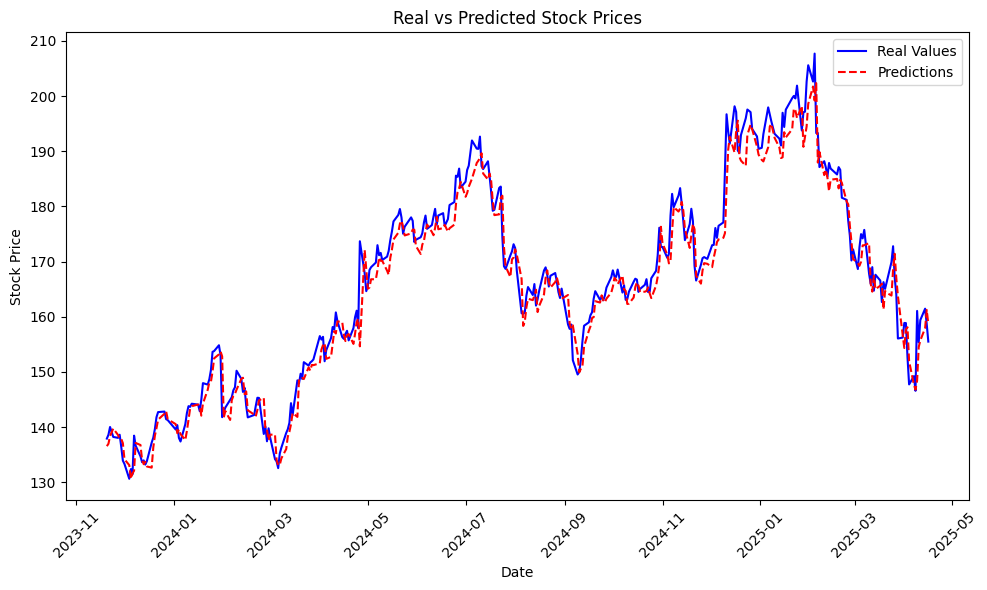

In [57]:
results_gru = evaluate_model_google(model_google_gru, test_loader, dates, train_size)

real_values_gru = results_gru['real_values']
predicted_values_gru = results_gru['predicted_values']
test_dates = results_gru['test_dates']

true_values_denorm_gru = real_values_gru * (price_max - price_min) + price_min
predictions_denorm_gru = predicted_values_gru * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm_gru,
    predictions=predictions_denorm_gru,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='GRU',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [58]:
model_google_gru_rev = SimpleGRU(input_size=5, hidden_size=64, output_size=1, num_layers=2)
optimizer_rev = torch.optim.Adam(model_google_gru_rev.parameters(), lr=0.001)

train_model(model_google_gru_rev, loss_fn, optimizer_rev, num_epochs, train_loader_rev)

Epoch [1/30], Train Loss: 0.0103
Epoch [2/30], Train Loss: 0.0009
Epoch [3/30], Train Loss: 0.0005
Epoch [4/30], Train Loss: 0.0004
Epoch [5/30], Train Loss: 0.0003
Epoch [6/30], Train Loss: 0.0003
Epoch [7/30], Train Loss: 0.0003
Epoch [8/30], Train Loss: 0.0003
Epoch [9/30], Train Loss: 0.0003
Epoch [10/30], Train Loss: 0.0003
Epoch [11/30], Train Loss: 0.0002
Epoch [12/30], Train Loss: 0.0002
Epoch [13/30], Train Loss: 0.0002
Epoch [14/30], Train Loss: 0.0002
Epoch [15/30], Train Loss: 0.0002
Epoch [16/30], Train Loss: 0.0002
Epoch [17/30], Train Loss: 0.0002
Epoch [18/30], Train Loss: 0.0002
Epoch [19/30], Train Loss: 0.0002
Epoch [20/30], Train Loss: 0.0002
Epoch [21/30], Train Loss: 0.0002
Epoch [22/30], Train Loss: 0.0002
Epoch [23/30], Train Loss: 0.0002
Epoch [24/30], Train Loss: 0.0001
Epoch [25/30], Train Loss: 0.0001
Epoch [26/30], Train Loss: 0.0001
Epoch [27/30], Train Loss: 0.0002
Epoch [28/30], Train Loss: 0.0001
Epoch [29/30], Train Loss: 0.0001
Epoch [30/30], Train Lo

GRU | PAST – Epsilon 0.00 – MAE: 2.7364 | SIM: 0.9999


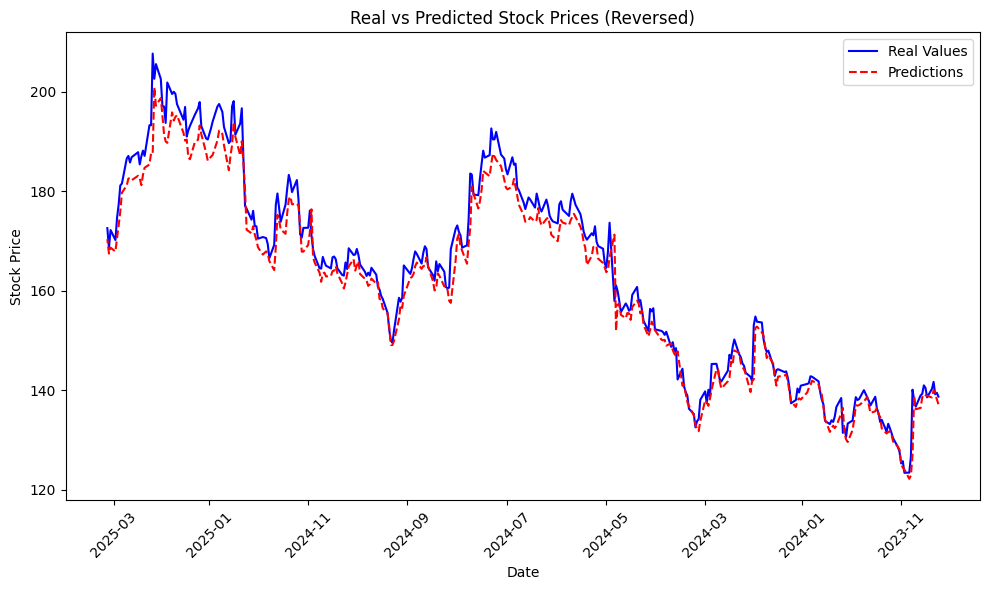

In [59]:
results_gru_rev = evaluate_model_google(model_google_gru_rev, test_loader_rev, dates_rev, train_size_rev)

real_values_gru_rev = results_gru_rev['real_values']
predicted_values_gru_rev = results_gru_rev['predicted_values']
test_dates_rev = results_gru_rev['test_dates']

min_len = min(len(test_dates_rev), len(real_values_gru_rev), len(predicted_values_gru_rev))
true_values_denorm_gru_rev = (real_values_gru_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
predictions_denorm_gru_rev = (predicted_values_gru_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
test_dates_rev = test_dates_rev[:min_len]

log_and_plot_predictions(
    true_values=true_values_denorm_gru_rev,
    predictions=predictions_denorm_gru_rev,
    test_dates=test_dates_rev,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='GRU',
    attack_name='PAST',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True,
    reverse=True
)

GRU | REV – Epsilon 0.01 – MAE: 2.5621 | SIM: 0.9998


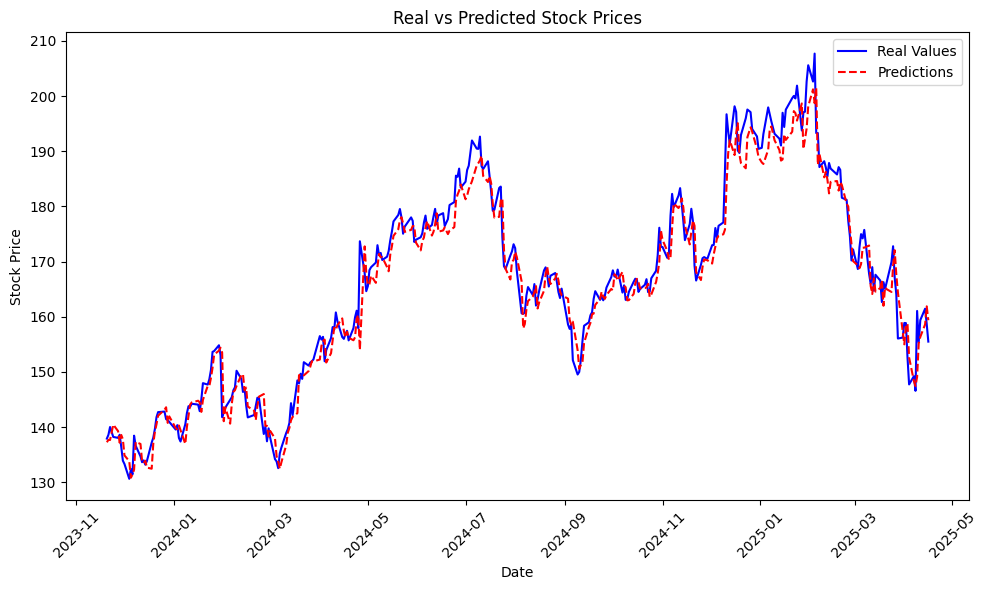

GRU | REV – Epsilon 0.10 – MAE: 6.0999 | SIM: 0.9992


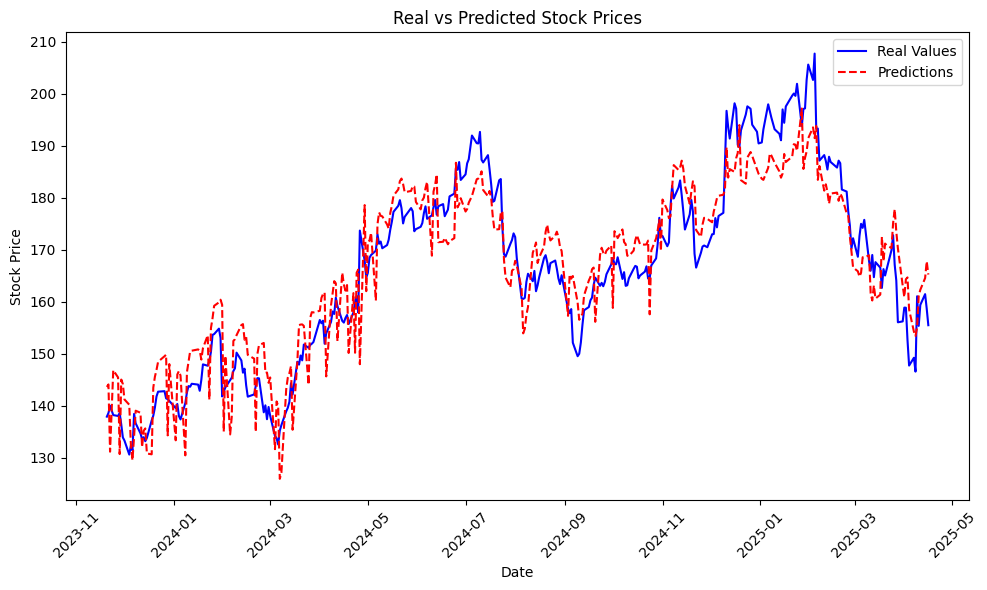

GRU | REV – Epsilon 0.20 – MAE: 12.2814 | SIM: 0.9971


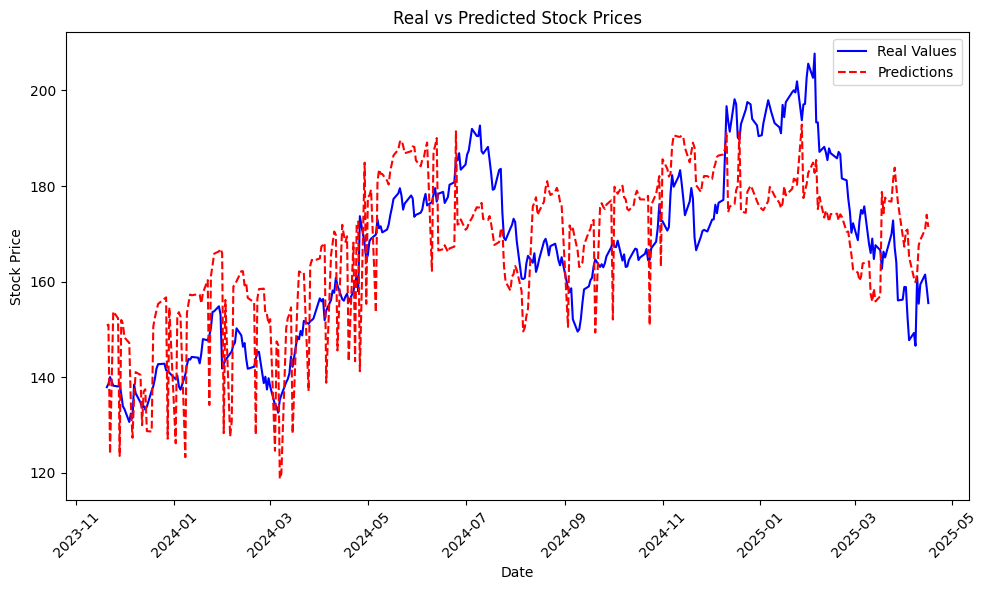

In [60]:
results_rev_gru = reverse_forecast_attack(
    model_google_gru_rev, model_google_gru,
    test_loader_rev, test_loader,
    epsilons,
    price_min, price_max
)

for esp, (true_vals, preds) in results_rev_gru.items():
  log_and_plot_predictions(
      true_values=true_vals,
      predictions=preds,
      test_dates=test_dates,
      true_values_rolling=None,
      predictions_rolling=None,
      model_name='GRU',
      attack_name='REV',
      epsilon=esp,
      res_tab=res_tab,
      similarity_fn=scalar_similarity,
      google=True
  )

In [61]:
display(res_tab)

Attack              NA      PAST       REV                     
ε                 0.00      0.00      0.01      0.10       0.20
Model Metric                                                   
LSTM  MAE     4.655826  5.893160  4.612915  4.777683   6.075597
      RMSE    5.859856  7.200629  5.802410  5.994869   7.821719
      SIM     0.999625  0.999700  0.999628  0.999535   0.999135
RNN   MAE     4.185904  2.440535  4.226511  4.882140   6.467864
      RMSE    5.206852  3.411808  5.252914  6.010685   8.093735
      SIM     0.999771  0.999861  0.999770  0.999729   0.999517
GRU   MAE     2.584147  2.736399  2.562097  6.099937  12.281350
      RMSE    3.459328  3.626750  3.466295  6.845379  12.934928
      SIM     0.999816  0.999880  0.999806  0.999166   0.997087